# Harmony Concise + L2SS-Py Demo

## What is Concise?
Concise is a Harmony service developed by PODAAC that allows users to concatenate multiple L2 granules together into a single granule. This concatenation is done by adding a new `subset_index` dimension to the resulting granule.

## What is L2SS-Py + Concise?
Harmony supports chaining multiple services together. The L2SS-Py + Concise chain allows users to combine spatial, temporal, and variable subsetting with granule concatenation.


## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which will be used for this notebook by visiting https://uat.urs.earthdata.nasa.gov. These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.


## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login. The function below will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

machine uat.urs.earthdata.nasa.gov login password

machine urs.earthdata.nasa.gov login password Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

`$ chmod 0600 ~/.netrc`


In [1]:
import xarray as xr
import tempfile
from IPython.display import display, JSON
from datetime import datetime
from harmony import BBox, Client, Collection, Request, Environment

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Create Harmony-py client.

*Note: Harmony-py does not currently support the parameter `turbo=true`, which is required for concatenation requests. Below is a hack that allows us to append `turbo=true` to the request query params.*

In [2]:
harmony_client = Client(env=Environment.PROD)

# Here be dragons
# harmony-py does not have any way of specifying turbo=true as
# a parameter in the request. Therefore we will abuse python to
# override an internal private method on the Client object so
# that we can manually add it.
# Look away, you don't want to see this.

orig_param_func = harmony_client._params

def new_params_func(*args) -> dict:
    params = orig_param_func(*args)
    params['turbo'] = 'true'
    return params

harmony_client._params = new_params_func
# End of horrible nasty hack

Contruct and validate Harmony request. This is a subsetting + concatenation request, so we are requesting both a spatial subset, variable subset, and concatenation request. 

In [3]:
collection = Collection(id='C2075141559-POCLOUD')

request = Request(
    collection=collection,
    spatial=BBox(-180, -90, 0, 0),
    variables=[
        'wind_speed', 
        'wind_dir'
    ],
    concatenate=True,
    max_results=5,
)

request.is_valid()

True

Submit Harmony job

In [4]:
job_id = harmony_client.submit(request)

Retrieve Harmony job status using job ID

In [5]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'CMR query identified 47267 granules, but the request has been limited to process only the first 5 granules because you requested 5 maxResults.',
 'progress': 0,
 'created_at': datetime.datetime(2021, 12, 13, 17, 25, 38, 962000, tzinfo=tzutc()),
 'updated_at': datetime.datetime(2021, 12, 13, 17, 25, 38, 962000, tzinfo=tzutc()),
 'request': 'https://harmony.earthdata.nasa.gov/C2075141559-POCLOUD/ogc-api-coverages/1.0.0/collections/wind_speed,wind_dir/coverage/rangeset?forceAsync=true&subset=lat(-90%3A0)&subset=lon(-180%3A0)&maxResults=5&concatenate=true&turbo=true',
 'num_input_granules': 5}

Wait until the Harmony request has finished processing. This is a blocking call.

In [6]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Create a temporary directory and download result into temp directory

In [7]:
temp_dir = tempfile.mkdtemp()
results = harmony_client.download_all(job_id, directory=temp_dir, overwrite=True)

In [8]:
futures = harmony_client.download_all(job_id)
file_names = [f.result() for f in futures]
file_names

['C2075141559-POCLOUD_merged.nc4']

Open concatenated granule using xarray. Notice the variable subset has been successfully executed -- only `wind_dir` and `wind_speed` vars are present.

In [9]:
ds = xr.open_dataset(file_names[0], decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (subset_index: 5, NUMROWS: 704, NUMCELLS: 42)
Coordinates:
    lat           (subset_index, NUMROWS, NUMCELLS) float32 ...
    lon           (subset_index, NUMROWS, NUMCELLS) float32 ...
Dimensions without coordinates: subset_index, NUMROWS, NUMCELLS
Data variables:
    subset_files  (subset_index) object ...
    time          (subset_index, NUMROWS, NUMCELLS) float64 ...
    wind_speed    (subset_index, NUMROWS, NUMCELLS) float32 ...
    wind_dir      (subset_index, NUMROWS, NUMCELLS) float32 ...
Attributes: (12/22)
    title:                            MetOp-B ASCAT Level 2 25.0 km Ocean Sur...
    title_short_name:                 ASCATB-L2-25km
    Conventions:                      CF-1.4
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-B ASCAT
    software_identification_level_1:  801
    ...                               ...
    rev_orbit_period:                 6081.7
    orbit_inclination:                98.7
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2013-06-10
    history_json:                     [{"date_time": "2021-12-13T08:33:13.731...

For each granule that makes up this concatenated granule, plot `wind_speed` for that granule using `subset_index` dimension.

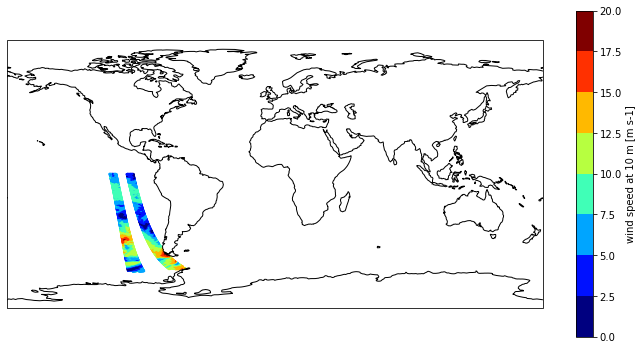

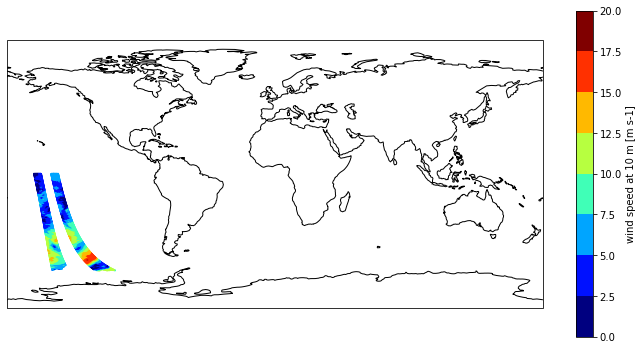

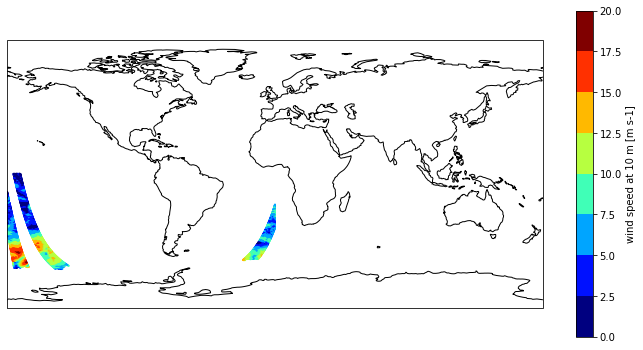

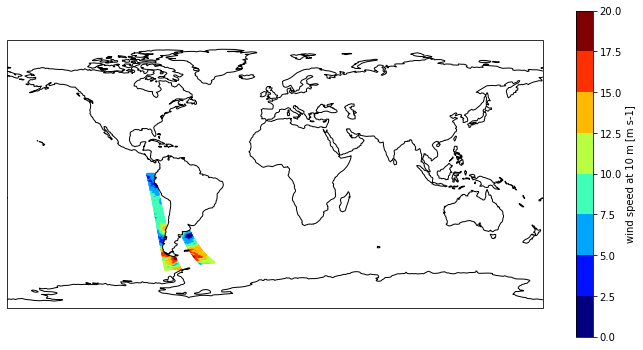

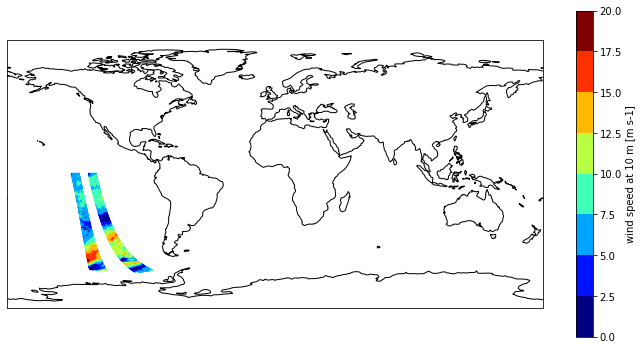

In [10]:
for index in range(0, 5):   
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    p = ds.isel(subset_index=index).plot.scatter(
        y="lat",
        x="lon",
        hue="wind_speed",
        s=1,
        levels=9,
        cmap="jet",
        ax=ax
    )
    
    ax.set_global()
    ax.coastlines()
    plt.show()

Plot `wind_speed` for all data in this concatenated granule. Notice that the data is within the spatial bounds we provided earlier (-180,-90,0,0)

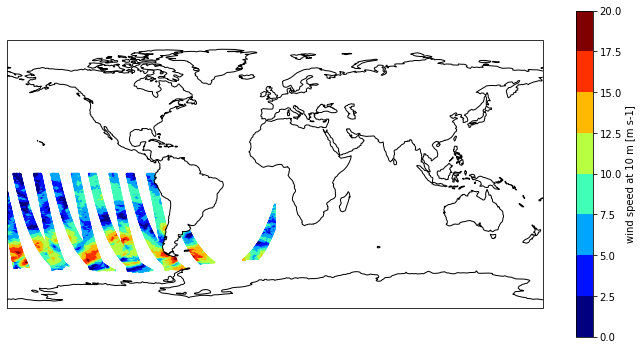

In [11]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

p = ds.plot.scatter(
    y="lat",
    x="lon",
    hue="wind_speed",
    s=1,
    levels=9,
    cmap="jet",
    ax=ax
)

ax.set_global()
ax.coastlines()
plt.show()